# xgboostを用いて、スプライスされやすい領域とそうでない領域の配列の学習を行う

## 準備

In [99]:
# オリジナルモジュールのインポート
from lib.introngap import PileUp
from lib.gbkparse import Seq_count

# モジュールのインポート
import itertools
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [100]:
# クラスのインスタンス化
gbk = Seq_count()

# gbkファイルの読み込み
gbk.read_gbk('../data/gbk/human_ttn.gb')

デフォルト値として、最もエクソンの多いNM_001267550.2を設定


# 各イントロンの両端n塩基を抽出し下記の条件でデータを分割する
スプライシングを受けやすい領域(highs): intron 120-220<br>
スプライシングを受けにくい領域(lows): intron 221-

## 各イントロンの5-prime側のn塩基にフォーカスし解析

In [101]:
# 各イントロンの両端n塩基を抽出し
n = 30

# 各イントロンの5-prime側のn塩基を抽出 
left_edges = []
for i in range(gbk.intron_num()):
    left_edges.append(str(gbk.intron_seq(i+1)[:n]))

In [102]:
# 領域の切り出し
high_s, high_e = 120, 220
low_s, low_e = 0, 45
# low_s, low_e = 220, gbk.intron_num()
left_edges_high = left_edges[high_s:high_e]
left_edge_low = left_edges[low_s:low_e] 

# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences_high = np.array([one_hot_encode(seq) for seq in left_edges_high])
encoded_sequences_low = np.array([one_hot_encode(seq) for seq in left_edge_low])

In [103]:
# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([encoded_sequences_high, encoded_sequences_low]))
y = pd.DataFrame(np.concatenate([np.ones(len(encoded_sequences_high)), np.zeros(len(encoded_sequences_low))]))

# XGBoostのインスタンス化
model = XGBClassifier(early_stopping_rounds=10, learning_rate=0.05, max_depth=8)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

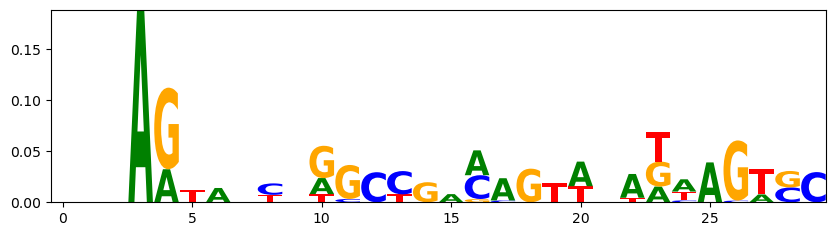

In [104]:
# logomakerを用いてモチーフを可視化
b_df_r = pd.DataFrame(model.feature_importances_.reshape(30,4))
b_df_r.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_r, shade_below=.5, fade_below=.5)

In [105]:
g_count = 0
for i in left_edges_high:
    if i[3] == "A":
        g_count += 1
print(g_count/len(left_edges_high))

g_count = 0
for i in left_edge_low:
    if i[3] == "A":
        g_count += 1
print(g_count/len(left_edge_low))

0.09
0.6888888888888889


## 各イントロンの5-prime側のn塩基にフォーカスし解析

In [106]:
    
# 各イントロンの3-prime側のn塩基を抽出
right_edges = []
for i in range(gbk.intron_num()):
    right_edges.append(str(gbk.intron_seq(i+1)[-n:]))

In [107]:
# 領域の切り出し
high_s, high_e = 120, 220
low_s, low_e = 0, 45
# low_s, low_e = 220, gbk.intron_num()
right_edges_high = right_edges[high_s:high_e]
right_edges_low = right_edges[low_s:low_e] 

# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences_high = np.array([one_hot_encode(seq) for seq in right_edges_high])
encoded_sequences_low = np.array([one_hot_encode(seq) for seq in right_edge_low])

In [108]:
# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([encoded_sequences_high, encoded_sequences_low]))
y = pd.DataFrame(np.concatenate([np.ones(len(encoded_sequences_high)), np.zeros(len(encoded_sequences_low))]))

# XGBoostのインスタンス化
model = XGBClassifier(early_stopping_rounds=10, learning_rate=0.1, max_depth=8)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

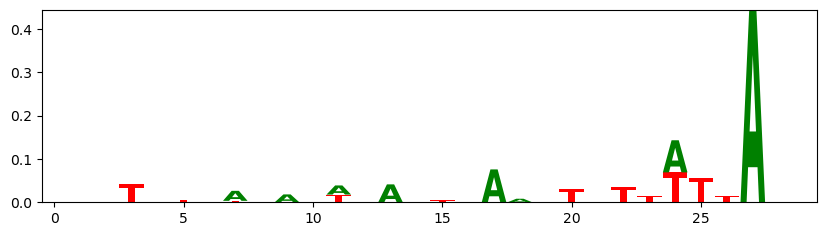

In [109]:
# logomakerを用いてモチーフを可視化
b_df_r = pd.DataFrame(model.feature_importances_.reshape(30,4))
b_df_r.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(b_df_r, shade_below=.5, fade_below=.5)

In [110]:
g_count = 0
for i in right_edges_high:
    print(i)
    if i[27] == "A":
        g_count += 1
print(g_count/len(right_edges_high))

GAACTAACATTGTGTTTCAAAAACTTTAAG
TAAAGTCAATTCTAAAAATGTCTCTTCAAG
AAATTTTAAAATTCAATACTATCCTTTAAG
AATTTCTAAAAGTGCATAATGTCTCTAAAG
TTAAACTTCAACTTTAACACTTTCTTAAAG
TGAATTTAAATGAAACCTTATCTTTTAAAG
TTATCTTCTTTAAAACTGCTGTCTTTAAAG
TCTACAAACATATTTTATAATCTTTTCAAG
CTCATATTCTTAAACCTAATCTTTCTAAAG
GTTTGATGGTATTGCCTGGTATCTTTTAAG
AACTCCCTAATCCTAAAATTATCTTTTAAG
AATACTTTAAAGTGAAATCTCTCTTTAAAG
AATTCACTTTTAATAATTACTCCTTTAAAG
AAGTGCTGCCTGTTGTTAATATTGTTTCAG
ACATGAAATACCTTGTATGTACTTTTAAAG
TTAAAATCTCTTAATATTGATATTTTGAAG
AATGCTCTTTAATAATTAATATCTTTAAAG
ATAAAATTTCCTTATACTTCATATTTCAAG
ATGTCCAACTTAAAGATAATATCTTTAAAG
TTTCCAACATTCTTAATAATATCTTTAAAG
AGAACTTAACAATAAACAATATCTTTAAAG
TGACACTAACTCTATTTGATATCTTTGAAG
AAAATTTTTCTCTAAATCATTTCGTTAAAG
TATTCCTAAATATAAATAATATCTTTAAAG
GTTTGTACCCTTGAATAAATATCTTTAAAG
TTTAATGCCTTCAAATGAAATGTTTTTAAG
AATCCTTATCATGAAATGATGTCTTTAAAG
AACTTATAAAATAAAATAATATTTTTAAAG
AAGTGTCTAAAATAATCAATGTCTCTCAAG
ATAATTTACAAAATAATAATCTTTTTAAAG
TTTCAAAATGTTCATAAAATTTCTTTTAAG
AGCTAACTAAAACACCTAATATCTTTAAAG
GTCCTAAA

In [111]:

g_count = 0
for i in right_edges_low:
    print(i)
    if i[27] == "A":
        g_count += 1
print(g_count/len(right_edge_low))

CACCCTAATTTATTTTCTCTTCTTTTTCAG
ACATAAAGGTGAATTGTTCTTGCTCTTCAG
ACTCTTGACTTTGTTCTCTTGTCCCCGCAG
TCCCAAACATTCATCTTTCCCTTCCCACAG
CAACGTGGGCTTTGTTTTAATCTTTTACAG
CATTCTTGACCTCTGCCTTTTGGTTTTCAG
AAGTAATCTACTTGGTCATTTCTAATCTAG
GTGTTTTCTTCCTTTCTCTATGAAAAGCAG
TAAAGTTTTTTCTTAAATCATTCTTTGCAG
CTCAAATCTTTATTTTACTCTAAACATCAG
CTATTTTCTTACTTTCTTTTGTATGATCAG
CTTAAATCTTGATTTTACTGTAATAATCAG
ATGTATTAATTCTGGAAACCTTGTCTCCAG
ATGGTATCACTGAGTTTCATTTCAATGCAG
ACTTTATTTTCTGACTCTGTTTCCATGTAG
CATTTTGTAATATAATTTGTAAAAATCTAG
ATCATTATTTATTTTTTCTCCTCTCTTCAG
TCTCAATGAGAAACTTTTGTCTTCTTTTAG
AAGCTAATATGAGGGGAATTCTCTTTCCAG
GATTTTTAAATTTTGTACATTTACATAAAG
TAAAAATTAACTGATGTTCTTAACTCTTAG
TTTTTAACAGACCATAATCTTTTTGCATAG
TTATTCATACATGCATGGTATTCTTTGCAG
ACGAAAGTATTGTGTGTCTTTGTTTTGCAG
ATCTACTTTCTTTTAAACATATTTTCACAG
TCCCTCTAAATCATGACCTTTCTCTTTCAG
TTGATTATTCCCTCCCCCAACTTTTTATAG
TCCCCTTTTTCCCCCACCTTTTTCTTGTAG
ATTGATTTATCTTTCTGTTATACACTTCAG
TAACATTCTTTTTCTCCCCATATTTCACAG
CATTCATCTTGTGTGTGTATGATTTTGCAG
AACCAAGAGATTATTTTATTTTTTCCCCAG
GACTCATA